In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns

from histaug.analysis.bootstrap_augmentations import compare_bootstraps
from histaug.utils.display import RENAME_MODELS, RENAME_FEATURE_EXTRACTORS, FEATURE_EXTRACTOR_GROUPS

In [2]:
df_slidewise = compare_bootstraps("none", "Macenko_slidewise")
df_patchwise = compare_bootstraps("none", "Macenko_patchwise")

df_slidewise["method"] = "slidewise"
df_patchwise["method"] = "patchwise"

df = (
    pd.concat([df_slidewise, df_patchwise])
    .reset_index()
    .set_index(["method", "model", "feature_extractor"])
    .drop(columns=["target"])
)
df

auroc_diff
method    model        feature_extractor            
slidewise Transformer  ctranspath          -0.045990
                       ctranspath          -0.068505
                       ctranspath          -0.063496
                       ctranspath          -0.011574
                       ctranspath          -0.083704
...                                              ...
patchwise AttentionMIL dino_p16            -0.036071
                       dino_p16            -0.054424
                       dino_p16             0.034286
                       dino_p16            -0.003754
                       dino_p16            -0.016827

[60750 rows x 1 columns]

Text(0, 0.5, 'Change in AUROC (original vs. normalised)')

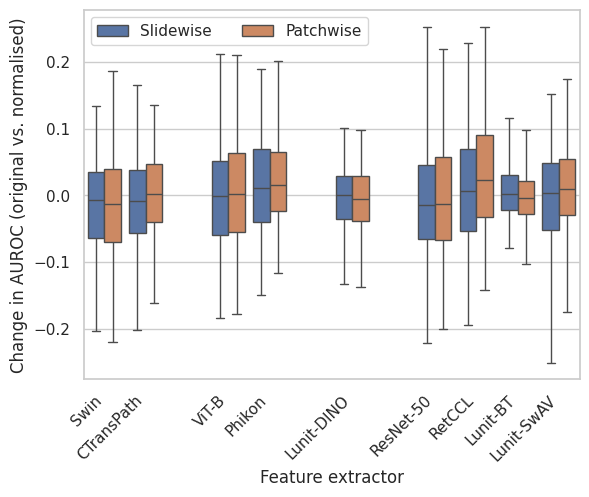

In [27]:
sns.set_theme(style="whitegrid")
# sns.violinplot(
#     data=df.query("model == 'Transformer'"),
#     x="feature_extractor",
#     y="auroc_diff",
#     hue="method",
#     split=True,
#     fill=False,
#     # inner="quart",
#     # density_norm="width",
#     native_scale=True,
# )
# sns.violinplot(
#     data=df.query("model == 'Transformer' and method == 'slidewise'"),
#     x="feature_extractor",
#     y="auroc_diff",
#     # hue="method",
#     # split=True,
#     fill=True,
#     # inner="quart",
#     # density_norm="width",
#     native_scale=True,
# )

df["Feature extractor"] = df.index.get_level_values("feature_extractor").map(RENAME_FEATURE_EXTRACTORS)
df["Stain normalisation"] = df.index.get_level_values("method").map(
    {"slidewise": "Slidewise", "patchwise": "Patchwise"}
)

# Boxplot with 95% confidence interval
sns.boxplot(
    data=df.query("model == 'Transformer'"),
    x="Feature extractor",
    y="auroc_diff",
    hue="Stain normalisation",
    order=[
        x
        for y in [
            [*([" " * i] if i != 0 else []), *[RENAME_FEATURE_EXTRACTORS[extractor] for extractor in extractors]]
            for i, extractors in enumerate(FEATURE_EXTRACTOR_GROUPS.values())
        ]
        for x in y
    ],
    # ensure 95% confidence interval is shown
    showfliers=False,
    whis=[2.5, 97.5],
    # show all data points
    # showmeans=True,
)

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left", ncol=2)
plt.ylabel("Change in AUROC (original vs. normalised)")

In [30]:
from functools import partial

d = (
    df.reset_index()
    .groupby(["method", "model", "feature_extractor"])["auroc_diff"]
    .agg(["mean", partial(pd.Series.quantile, q=0.025), partial(pd.Series.quantile, q=0.975)])
)
d.columns = ["mean", "ci_lo", "ci_hi"]
d = (
    "$"
    + d["mean"].map(lambda x: f"{x:+.3f}")
    + "\\ ["
    + d["ci_lo"].map(lambda x: f"{x:.3f}")
    + ", "
    + d["ci_hi"].map(lambda x: f"{x:.3f}")
    + "]$"
)
d = d.unstack("method")
d = d.reset_index()
d = d.sort_values(
    by=["model", "feature_extractor"],
    key=lambda series: series.map(
        lambda x: list(
            RENAME_FEATURE_EXTRACTORS.keys() if series.name == "feature_extractor" else RENAME_MODELS.keys()
        ).index(x)
    ),
)
d["model"] = d["model"].map(RENAME_MODELS)
d["feature_extractor"] = d["feature_extractor"].map(RENAME_FEATURE_EXTRACTORS)
d = d.set_index(["model", "feature_extractor"])
d.index.names = ["Model", "Feature extractor"]
d = d.reindex(["slidewise", "patchwise"], axis=1)
d.columns = [{"slidewise": "Slidewise", "patchwise": "Patchwise"}[col] for col in d.columns]
print(d.to_latex(column_format="ll|cc", escape=False))

\begin{tabular}{ll|cc}
\toprule
 &  & Slidewise & Patchwise \\
Model & Feature extractor &  &  \\
\midrule
\multirow[t]{9}{*}{Transformer} & Swin & $-0.017\ [-0.208, 0.136]$ & $-0.015\ [-0.220, 0.189]$ \\
 & CTransPath & $-0.009\ [-0.202, 0.166]$ & $+0.001\ [-0.162, 0.136]$ \\
 & ViT-B & $+0.001\ [-0.185, 0.214]$ & $+0.006\ [-0.178, 0.211]$ \\
 & Phikon & $+0.015\ [-0.150, 0.190]$ & $+0.024\ [-0.117, 0.202]$ \\
 & Lunit-DINO & $-0.005\ [-0.138, 0.101]$ & $-0.008\ [-0.139, 0.098]$ \\
 & ResNet-50 & $-0.005\ [-0.223, 0.253]$ & $-0.004\ [-0.206, 0.219]$ \\
 & RetCCL & $+0.010\ [-0.197, 0.232]$ & $+0.034\ [-0.145, 0.254]$ \\
 & Lunit-BT & $+0.006\ [-0.079, 0.116]$ & $-0.003\ [-0.103, 0.102]$ \\
 & Lunit-SwAV & $-0.011\ [-0.252, 0.154]$ & $+0.010\ [-0.175, 0.176]$ \\
\cline{1-4}
\multirow[t]{9}{*}{AttMIL} & Swin & $-0.001\ [-0.173, 0.178]$ & $+0.014\ [-0.145, 0.179]$ \\
 & CTransPath & $-0.006\ [-0.127, 0.086]$ & $-0.002\ [-0.084, 0.092]$ \\
 & ViT-B & $+0.004\ [-0.121, 0.160]$ & $+0.001\ [